# Recommender System - 심화 과제 \#1 (답안)

## 개요

Item2Vec을 PyTorch로 구현해본다.

- Item2Vec에 가장 적합한 데이터는 유저 혹은 세션 단위로 비슷한 의도를 가지고 아이템을 소비한 로그입니다
- 무비렌즈 데이터는 Item2Vec을 수행하기에 적합한 데이터는 아니지만 Item2Vec을 통한 연관 추천의 결과가 잘 드러나기 때문에 해당 데이터를 실습으로 사용하겠습니다.


- 과제는 **<font color=#5F71F7>과제 HOMEWORK</font>** 라는 키워드로 표시하였습니다.
- <code><font color=#007979># FILL HERE : ... #</font></code>라고 쓰여 있는 부분을 채워넣으시면 됩니다.


- **그 외의 부분은 따로 건드리지 않으셔도 됩니다.**

- **제출은 따로 하지 않습니다.**

---

## 0. 전처리

### 0.1. 기본 설정

In [1]:
from typing import Union, Tuple, List

import numpy as np
import random
import pandas as pd
from datetime import datetime, date
from tqdm.notebook import tqdm
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score
from tqdm import tqdm

import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

# from IPython.display import Image
from joblib import Parallel, delayed
import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader

In [2]:
###############################################################################
# 주어진 결과와 정확히 비교하기 위한 random seed 고정
###############################################################################

seed = 0  # 바꾸지 마시오!
random.seed(seed)
np.random.seed(seed)

### 0.2. MovieLens 데이터셋 불러오기


#### 활용 데이터셋 : MovieLens 100k Dataset

- 출처 :
    <br>Harper, F. M., & Konstan, J. A. (2015). **The MovieLens Datasets: History and Context.** ACM Transactions on Interactive Intelligent Systems (TIIS), 5(4), 1-19. http://dx.doi.org/10.1145/2827872
    
    
- 본 데이터셋은 직접 GroupLens 측을 통해 Naver Boostcamp RecSys 강좌 내에서 활용 및 재배포를 허가받은 데이터셋입니다.
    <br> 과제 외의 목적으로 이용하고자 할 경우 [원시 데이터](https://grouplens.org/datasets/movielens/)를 직접 다운받아 사용하시기 바랍니다.
    <br> ( 각 데이터셋에 대한 README.txt 파일을 통해 라이센스 정보를 확인하실 수 있습니다. )

In [3]:
import os

In [4]:
# 평점 데이터
ratings_df = pd.read_csv('/opt/ml/wine/dataset/train_data/train_data.inter', sep='\t', encoding='utf-8')

# 영화 데이터
items_df = pd.read_csv('/opt/ml/wine/dataset/train_data/train_data.item', sep='\t', encoding='utf-8')


In [5]:
from sklearn.model_selection import train_test_split

ratings_df['liked'] = np.where(ratings_df['user_rating:float'] >= 4, 1, 0)
ratings_df['item_id:token'] = ratings_df['item_id:token']
ratings_df['user_id:token'] = ratings_df['user_id:token']


### 0.3. MovieLens 데이터에서 positive sample 뽑기

In [6]:
positive_samples = ratings_df.copy()
positive_samples = positive_samples[positive_samples['liked'] == 1]
positive_samples = positive_samples[['user_id:token', 'item_id:token', 'liked']]

In [7]:
# 단어가 최소 3회 이상 등장해야 학습되고 모델에 저장됨
min_count = 3
# 1개의 positive sample당 negative sample의 개수
negative = 5

In [8]:
movie_ids_for_training = list()
for movie_id in ratings_df['item_id:token'].unique():
    if positive_samples[positive_samples['item_id:token'] == movie_id].shape[0] >= min_count:
        movie_ids_for_training.append(movie_id)

In [9]:
def sampler(movie_ids, user_ids):
        
    new_positive_samples = dict()
    new_positive_samples['user_id:token'] = list()
    new_positive_samples['w_movie_id'] = list()
    new_positive_samples['c_movie_id'] = list()

    user_negative_samples = dict()

    for user_id in tqdm(user_ids):
        user_positive_samples = positive_samples[positive_samples['user_id:token'] == user_id]
        user_movies = user_positive_samples['item_id:token'].tolist()
        # sampling을 위해 각 user id의 negative movies를 저장
        user_neg_movies = [movie_id for movie_id in movie_ids if movie_id not in user_movies]
        user_negative_samples[user_id] = np.array(user_neg_movies)
        for w_movie_id in user_movies:
            # 단어가 최소 등장 횟수를 만족하지 않음
            if w_movie_id not in movie_ids_for_training:
                continue
            for c_movie_id in user_movies:
                if c_movie_id == w_movie_id:
                    continue
                new_positive_samples['user_id:token'].append(user_id)
                new_positive_samples['w_movie_id'].append(w_movie_id)
                new_positive_samples['c_movie_id'].append(c_movie_id)
    
    return [new_positive_samples, user_negative_samples]


def parallel(func, movie_ids, user_ids, num_cpu):

    user_chunks = np.array_split(user_ids, num_cpu)

    print('Parallelizing with ' +str(num_cpu)+'cores')
    with Parallel(n_jobs = num_cpu, backend="multiprocessing") as parallel:
        results = parallel(delayed(func)(movie_ids, user_chunks[i]) for i in range(num_cpu))

    for i,data in enumerate(results):
        if i == 0:
            pos = data[0]
            neg = data[1]
        else:
            pos.update(data[0])
            neg.update(data[1])

    return pd.DataFrame(pos), neg

movie_ids = ratings_df['item_id:token'].unique()
user_ids = ratings_df['user_id:token'].unique()
import random
sample_size = len(user_ids) // 5
sampled_users =  np.random.choice(user_ids, sample_size)

new_positive_samples, user_negative_samples = parallel(sampler, movie_ids, sampled_users, 8)


Parallelizing with 8cores


100%|██████████| 28870/28870 [07:03<00:00, 68.14it/s]


In [ ]:
for user_id in tqdm(user_negative_samples):
    user_negative_samples[user_id] = np.array(user_negative_samples[user_id])

100%|██████████| 209358/209358 [00:27<00:00, 7708.09it/s]


### 0.5. SGNS 모델에 사용할 데이터셋 만들기

In [ ]:
new_positive_samples['user_id:token'] = new_positive_samples['user_id:token'].astype("category")
new_positive_samples['w_movie_id'] = new_positive_samples['w_movie_id'].astype("category")
new_positive_samples['c_movie_id'] = new_positive_samples['c_movie_id'].astype("category")

In [ ]:
new_positive_samples

,user_id:token,w_movie_id,c_movie_id
0,545955,54034,54464
1,545955,54464,54034
2,362248,47695,71669
3,362248,71669,47695
4,567072,53189,37665
...,...,...,...
10393029,614321,70299,54464
10393030,601255,30449,406
10393031,601255,406,30449
10393032,1060422,52718,51545


In [ ]:
train_df, test_df = train_test_split(
    new_positive_samples, random_state=seed, test_size=0.20
)
print('학습 데이터 크기:', train_df.shape)
print('테스트 데이터 크기:', test_df.shape)

학습 데이터 크기: (8314427, 3)
테스트 데이터 크기: (2078607, 3)


In [ ]:
# PyTorch의 DataLoader에서 사용할 수 있도록 변환
train_dataset = TensorDataset(torch.LongTensor(np.array(train_df)))
test_dataset = TensorDataset(torch.LongTensor(np.array(test_df)))

---

## 1. PyTorch로 SGNS 구현하기

### <font color='#5F71F7'>과제 HOMEWORK (1)</font>
### 1.1. `Negative Sampler` 클래스 구현하기
- HINT: user_negative_samples에 user id 별 전체 negative samples 정보를 가진 Dictionary이다. (i.e. keys: user id, items: list of negative samples)

In [ ]:
class Negative_Sampler(nn.Module):
    """
    Negative Sampler

    Args:
        - user_negative_samples: (Dict) keys: user id, items: list of negative samples
        - n_negs: (int) negative sample의 수
    Shape:
        - Input: (torch.Tensor) user id들. Shape: (batch size,)
        - Output: (torch.Tensor) sampling된 negative samples. Shape: (batch size, n_negs)
    """
    def __init__(self, user_negative_samples, n_negs):
        super(Negative_Sampler, self).__init__()
        self.user_negative_samples = user_negative_samples
        self.n_negs = n_negs

    def forward(self, user_ids):
        user_ids = user_ids.to('cpu').numpy()
        negative_samples = np.array([
            # FILL HERE : USE np.random.choice(), self.user_negative_samples, self.n_negs #
            np.random.choice(a=self.user_negative_samples[user_id], size=self.n_negs,replace=False)
            for user_id in user_ids
        ])
        return torch.from_numpy(negative_samples)


In [ ]:
class SGNS(nn.Module):
    """
    Skip-Gram with Negative Sampling

    Args:
        - n_items: (int) 전체 아이템의 수
        - emb_dim: (int) Embedding의 Dimension
        - user_negative_samples: (Dict) user id 별 전체 negative sample
        - n_negs: (int) negative sample의 수
    Shape:
        - Input: (torch.Tensor) input features, (user id, 중심 item id, 주변 item id). Shape: (batch size, 3)
        - Output: (torch.Tensor) sampling된 negative samples와 positive sample의 Loss 합. Shape: ()
    """
    def __init__(self, n_items, emb_dim, user_negative_samples, n_negs ,device=torch.device('cpu')):
        super(SGNS, self).__init__()

        # initialize Class attributes
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.user_negative_samples = user_negative_samples
        self.n_negs = n_negs
        self.negative_sampler = Negative_Sampler(self.user_negative_samples, self.n_negs)

        # define embeddings
        # 중심 아이템
        self.w_item_embedding = nn.Embedding(self.n_items, self.emb_dim) # FILL HERE : USE nn.Embedding() #
        # 주변 아이템
        self.c_item_embedding = nn.Embedding(self.n_items, self.emb_dim) # FILL HERE : USE nn.Embedding() #

        self.sigmoid = nn.Sigmoid()

        self.loss_fn = nn.BCELoss()

        self.apply(self._init_weights)
        self.device = device
        self.to(device)

    # initialize weights
    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)

    def forward(self, input_feature):
        batch_size = input_feature.size()[0]

        user_ids, w_item, c_item = torch.split(input_feature, [1, 1, 1], -1)
        # 유저 id
        user_ids = user_ids.squeeze(-1)
        # 중심 아이템
        w_item = w_item.squeeze(-1)
        # 주변 아이템 (positive sample)
        c_item = c_item.squeeze(-1)
        # 주변 아이템 negative sampling
        neg_c_items = self.negative_sampler(user_ids)

        # 중심 아이템 embedding
        w_item_e = self.w_item_embedding(w_item).to(self.device) # FILL HERE : USE self.w_item_embedding() #
        # 주변 아이템 (positive sample) embedding
        c_item_e = self.c_item_embedding(c_item).to(self.device) # FILL HERE : USE self.c_item_embedding() #
        # 주변 아이템 (negative sample) embedding
        neg_c_items_e = self.c_item_embedding(neg_c_items).to(self.device) # FILL HERE : USE self.c_item_embedding() #
                         # HINT: neg_c_items_e.shape == (batch_size, self.n_negs, self.emb_dim)

        w_item_e = w_item_e.view(batch_size, 1, self.emb_dim)
        c_item_e = c_item_e.view(batch_size, self.emb_dim, 1)
        neg_c_items_e = neg_c_items_e.permute(0, 2, 1)

        pos_output = torch.bmm(w_item_e, c_item_e) # FILL HERE : Use torch.bmm() #
        pos_output = pos_output.squeeze(-1)
        pos_output = self.sigmoid(pos_output).squeeze(-1)

        pos_y = torch.ones(pos_output.size()).to(self.device)
        pos_loss = self.loss_fn(pos_output, pos_y)

        neg_output = torch.bmm(w_item_e, neg_c_items_e) # FILL HERE : Use torch.bmm() #
        neg_output = neg_output.squeeze(-1)
        neg_output = self.sigmoid(neg_output)

        neg_y = torch.zeros(neg_output.size()).to(self.device)
        neg_loss = self.loss_fn(neg_output, neg_y)

        return pos_loss + neg_loss


### 1.3. SGNS 모델 학습하기

In [ ]:
# Reference - https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def train_loop(dataloader, model, optimizer, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0

    for batch, (X,) in enumerate(dataloader):
        X = X.to(device)
        # Compute prediction and loss
        loss = model(X)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (batch+1) % 100 == 0:
            loss, current = loss.item(), (batch+1) * len(X)
            print(f"Loss: {loss:>7f} | [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches

    return train_loss


def test_loop(dataloader, model, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss= 0

    with torch.no_grad():
        for X, in dataloader:
            X= X.to(device)
            loss = model(X)
            test_loss += loss.item()
    test_loss /= num_batches
    print(f"Test Error:\n\tAvg Loss: {test_loss:>8f}")
    return test_loss


In [ ]:
def train_and_test(train_dataloader, test_dataloader, model, optimizer, epochs, device):
    train_loss, test_loss = list(), list()

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_result= train_loop(train_dataloader, model, optimizer, device)
        train_loss.append(train_result)
        test_result = test_loop(test_dataloader, model, device)
        test_loss.append(test_result)
        print("-------------------------------\n")
    print("Done!")

    return train_loss, test_loss


In [ ]:
######## Hyperparameter ########
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

batch_size = 2048
data_shuffle = True
emb_dim = 512
epochs = 5
learning_rate = 0.001

n_items = ratings_df['item_id:token'].nunique()
################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=data_shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=data_shuffle)

model = SGNS(n_items, emb_dim, user_negative_samples, negative, device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

In [ ]:
train_loss, test_loss = train_and_test(train_dataloader, test_dataloader, model, optimizer, epochs, device)

Epoch 1
-------------------------------


IndexError: index out of range in self

### 1.4. SGNS 모델을 활용하여 가장 비슷한 영화 찾기
- SGNS 모델의 중심 아이템 Embedding을 활용한다.

In [ ]:
def get_most_similar(
    model: SGNS,
    movie_id: int,
    n: int,
    n_movies: int
) -> List:
    """
    해당 movie id와 cosine similarity가 가장 높은 n개의 movie id를 반환합니다.

    :param model: (SGNS) SGNS model
    :param movie_id: (int) 기준이 되는 movie id
    :param n: (int) 반환하는 movie의 수
    :param n_movies: (int) 전체 movie의 수
    :return: (List) n개의 movie id list
    """
    input_tensor = torch.tensor(movie_id)
    movie_embedding = model.w_item_embedding(input_tensor)
    movie_embedding = movie_embedding.squeeze(-1)
    similarity_list = list()
    for m_id in range(n_movies):
        if m_id == movie_id:
            continue
        m_tensor = torch.tensor(m_id)
        m_embedding = model.w_item_embedding(m_tensor)
        m_embedding = m_embedding.squeeze(-1)
        similarity = torch.nn.CosineSimilarity(dim=0)(movie_embedding, m_embedding)
        similarity_list.append((m_id, similarity.item()))
    similarity_list.sort(key=lambda x: x[1], reverse=True)

    return similarity_list[:n]

### 1.5. SGNS 모델을 활용한 영화에 대한 연관 추천

In [ ]:
genre_list = ['Action', 'Adventure', 'Animation',
             'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
             'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
             'Thriller', 'War', 'Western']

#### Toy Story (1995) 예제

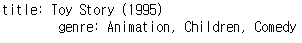

In [ ]:
n = 10
movie_id = 0
n_movies = ratings_df['movie_id'].nunique()

similar_movies = get_most_similar(model, movie_id, n, n_movies)

#### Toy Story (1995)와 비슷한 영화 10개

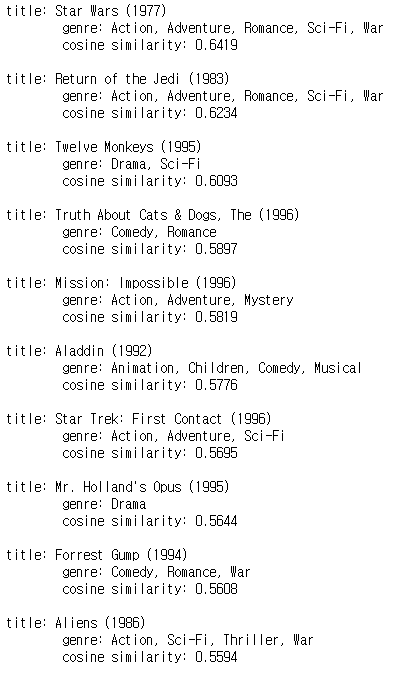

In [ ]:
for similar_movie_id, similarity in similar_movies:
    temp_df = movies_df[movies_df.movie_id == similar_movie_id]
    movie_title = temp_df['movie_title'].item()
    genre_df = temp_df[genre_list]
    genre = genre_df.columns[genre_df.iloc[0,:].values == 1]
    print('title: %s\n\tgenre: %s\n\tcosine similarity: %.4f\n' % (movie_title, ', '.join(genre), similarity))

#### Heavy Metal (1981) 예제

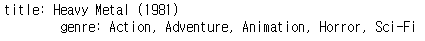

In [ ]:
n = 10
movie_id = 100
n_movies = ratings_df['movie_id'].nunique()

similar_movies = get_most_similar(model, movie_id, n, n_movies)

#### Heavy Metal (1981)와 비슷한 영화 10개

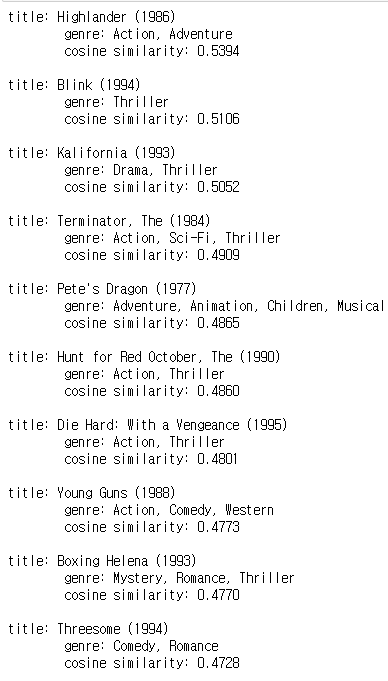

In [ ]:
for similar_movie_id, similarity in similar_movies:
    temp_df = movies_df[movies_df.movie_id == similar_movie_id]
    movie_title = temp_df['movie_title'].item()
    genre_df = temp_df[genre_list]
    genre = genre_df.columns[genre_df.iloc[0,:].values == 1]
    print('title: %s\n\tgenre: %s\n\tcosine similarity: %.4f\n' % (movie_title, ', '.join(genre), similarity))

## WARNING

> 본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다.
<br>본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.
<br>다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다.
<br>이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.